# Unsupervised Learning

In this section we begin exploring some unsupervised learning concepts.

We have two main goals from this section:
1. Feature Importance Determination
2. Identifiying Similiar Player Profiles of athletes with and without NIL Evaluations

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Since our pipeline is not up and running yet, let's just import the traintestsplit function
from python_scripts.traintestsplit import custom_train_test_split

In [3]:
# Read in the cleaned CSV  for football
dfFootball = pd.read_csv("cleaned_files/football_clean.csv")

# Since we cannot work with any NAN values and we are in the process of data cleaning we are going to ignore these values for now...
dfFootballClean = dfFootball.dropna()
print(dfFootballClean.shape)

(499, 28)


In [5]:
X_train, y_train, X_valid, y_valid, X_test, y_test = custom_train_test_split(dfFootballClean)
print(X_train.shape)
print(y_train.shape)

(61, 28)
(61,)


## Feature Importance Determination

The outputs of this feature importance determination will be crucial in plotting and visualizing things from the KMeans Effort Below!

Since our goal is to reduce our problem down for visualization purposes we are going to explore options in which the number of components is either 2 or 3 although a further analysis regarding the importance of features should also be performed.

It is sometimes good for very large, high-dimensional datasets to use PCA and then apply t-SNE/UMAP after!

#### Principal Components Analysis (PCA)

- A deviation from PCA would be to perform information gain (IG) techniques for each column in our feature space against the ground truth label (the target). This method still suffers from information loss however.
    - A method of creating a new feature which is linearly independent from other features. You would take k PC's which is assumed to be < # features
    - IF YOU ARE USING PCA OR ANY METHOD TO REDUCE THE NUMBER OF FEATURES YOU MUST APPLY **AFTER** TRAIN/TEST/SPLIT TO AVOID DATA LEAKAGE!!!!!!!!!
    - Creating a scatter plot post PCA is neat. It is also cool to look at a heatmap of the original features and the principal components
    - BIPLOTS:
        - combines a score plot and a loadings plot in a single graph
        - Basically you plot all of your data on the pricipal components (lets say 2 in this case) and then you can plot the ORIGINAL features in this space! The angle between vectors in the original feature space can tell us correlation!
    - SCREE PLOTS:
        - Plots the eigenvalues from PCA
        - pca.explained_variance_ from the output of the PCA var
        - Kaiser Heursitic -- if the elbow is tough to find, keep all eigenvalues with a score of at least 1
    - If the number of principal components is too big then you know that some kind of non-linear technique like kernel PCA might be required

In [31]:
def custom_Scree(X_train, n_comp=8, threshold=0.8):
    """
        :: Input(s) ::
            X_train - training data
            n_comp - the number of components that we are going to extract with PCA
            threshold - the amount of explained variance that the user would like to be captured by the minimum number of pricipal components
        :: Output(s) ::
            None
        :: Explaination of Function ::
        This fucntion performs Principal Components Analysis (PCA) on the training data that was provided by "traintestsplit.ipynb".
        The goal here is two fold:
            1. Generate a Scree Plot that incorporates an explained varaince ratio
            2. Help the user determine the minumum number of components in order to consider utilizing PCA
    """

    # We need to reduce the columns of this dataframe down to only those columns that are non-categorical!
    # For now I can just implement within this fucntion but maybe this will be part of the data cleaning later on?
    cols2Keep = ['HEIGHT_IN', 'WEIGHT_LBS', 'SKILL_', 'COLLDIST_MI',
                 'NUMOFF', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG']
    
    X_train = X_train[cols2Keep]

    # Normalize the data prior to performing PCA!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train)
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_train_Norm)

    # Since the n_comp is dynamic, we need a dynamic way to show the PC's
    PCs = []
    for i in range(n_comp):
        PCs.append('PC{}'.format(i+1))

    # Generate the Cumulative Sum of Explained Variance
    dfCumul = pd.DataFrame({'explained_var_ratio': pca.explained_variance_ratio_,
                            'PC': PCs})
    
    dfCumul['cumulative_variance'] = dfCumul['explained_var_ratio'].cumsum()
    threshold = threshold
    n_components_thresh = np.argmax(dfCumul['cumulative_variance'] >= threshold) + 1

    # Generate the Scree Plot
    dfScree = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_),
                            'PC': PCs})
    
    plt.figure(figsize=(8,6))
    plt.plot(dfScree['PC'],
             dfScree['eigenvalue'],
             color='skyblue')
    plt.xlabel('Principal Component (PC)')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')

    plt.axvline(dfScree['PC'][n_components_thresh - 1],
                color='red',
                label="At least {:.0f}% of Varaince Accounted for with {} PC's".format(threshold*100, n_components_thresh))
    
    plt.legend()
    plt.show()

    return None

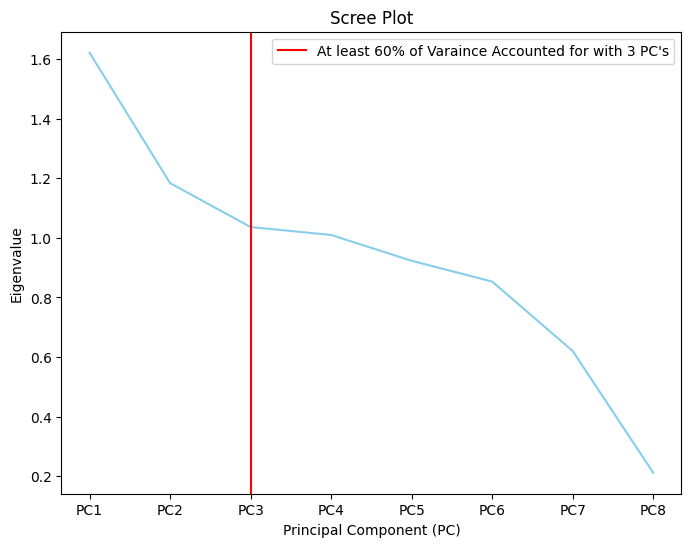

In [32]:
custom_Scree(X_train, n_comp=8, threshold=0.6)

In [36]:
def custom_BiPlot(X_train):
    """
        :: Input(s) ::
        :: Output(s) ::
        :: Explaination of Function ::
    """
    # We need to reduce the columns of this dataframe down to only those columns that are non-categorical!
    # For now I can just implement within this fucntion but maybe this will be part of the data cleaning later on?
    cols2Keep = ['NUMOFF', 'HEIGHT_IN', 'WEIGHT_LBS', 'SKILL_', 'COLLDIST_MI',
                 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG']
    
    X_train = X_train[cols2Keep]

    # Normalize the data prior to performing PCA!
    # This is crucial as we do not want magnitude of a feature to play a role
    X_train_Norm = StandardScaler().fit_transform(X_train)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_Norm)

    # The 'scores' are the individual points that make up the scatterplot in 2 dimensions
    # X_pca

    # The 'vectors' are the loadings that help map the original features onto our scatterplot
    # The COSINE of the angle between two variable markers is the coefficent of correlation between those variables!
    # If one of your vectors follows the x or y axis then you can correlate the variable marker and the PC!
    # You can take the dot product of your point in 2D PC Space with each of these variable markers to "reconstruct" in the original feature space!
    
    # X = pca.components_[i,0]
    # Y = pca.components_[i,1]
    
    coeff = np.transpose(pca.components_[0:2, :])
    maxdim = 8

    xs = X_pca[:,0]
    ys = X_pca[:,1]

    n = min(coeff.shape[0], maxdim)
    scalex = 2.0 / (xs.max() - xs.min())
    scaley = 2.0 / (ys.max() - ys.min())
    text_scale_factor = 1.5

    plt.figure(figsize=(8, 6))
    plt.scatter(xs * scalex, ys * scaley, s=1)

    for i in range(n):
        plt.arrow(0,0,coeff[i,0],coeff[i,1],color='red',alpha=0.5)
        plt.text(
            coeff[i,0] * text_scale_factor,
            coeff[i,1],
            cols2Keep[i],
            color='g',
            ha='center',
            va='center'
        )
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid()
    plt.tight_layout()
    plt.show()
    return None

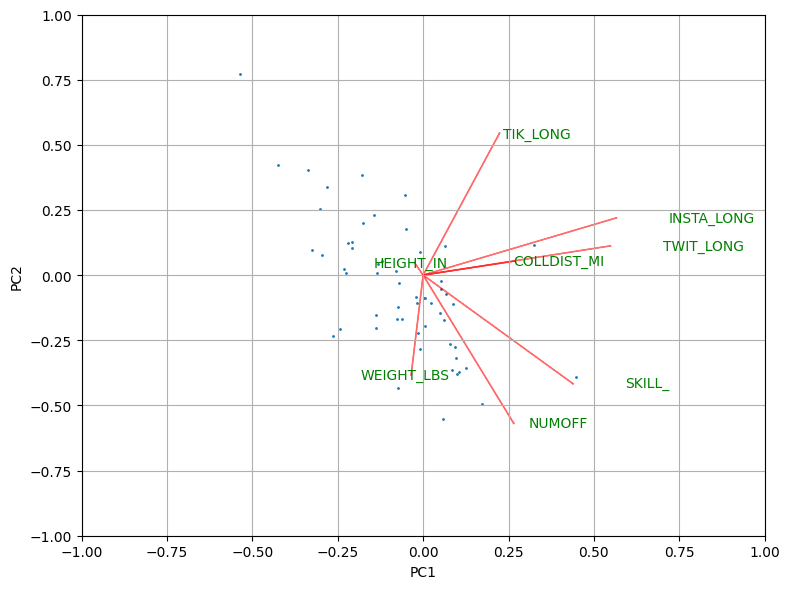

In [37]:
custom_BiPlot(X_train)

#### Multidimensional Scaling (MDS)

- Distance preserving low-dimensional projection
- Locally influenced
- If clusters are far apart in the OG data, then they will be far apart in the MDS projection
- weights can be introduced to handle missing data in MDS! We have lots of missing data in this project...

In [ ]:
# ===== MDS =====
from sklearn.manifold import MDS
# X_norm = StandardScaler().fit_transform(X_not_norm)

# mds = MDS(n_components=2)
# X_mds = mds.fit_transform(X_norm)

# plot(X_mds, output, [NAMES_OF_CLUSTERS])
# ===============

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

- Finds a low-dim output
    - Preserves similiaries in high-dim data
    - It is focused on preserving LOCAL DISTANCES between neighbors, not so much global structure
    - Perplexity is the key parameter
        - Experiment with multiple values here!
    - Can give different output everytime it runs!

In [ ]:
# ==== tSNE =====
from sklearn.manifold import TSNE
# tsne = TSNE(random_state=0)
# X_tsne = tsne.fit_transform(X_norm)

# plot(X_tsne, output, [NAMES_OF_CLUSTERS])
# ===============

#### Uniform Manifold Approximation & Projection (UMAP)

- Similiar to t-SNE --> Preserves local neighborhood structure
- But it also preserves some global structure too!
- It is a useful technique for plotting AS WELL AS clustering whereas t-SNE should not be used in clustering...

## Similiar Player Profiles

Notes regarding KMeans clustering:
- Different intializations can result in different solutions. Performing multiple runs is a good idea.
    - Be careful about where you start
    - Could place the first one randomly and the next one could be as far away as possible
- Centroid is typically the mean of the points in the cluster.
    - This works only when the values are continuous in nature. K-Medoid can be used if non-continuous columns are used.
- "Closeness" can take the form of Euclidean Distance, Cosine Similiarity, Correlation, etc

KMeans works well on simple clusters that are similiar in size, well seperated, and globular. Complex shapes... not so much...

##### Visualization Tips

When it comes to plotting this data it will be difficult to use normal ol KMeans because our data has lots of columns.
- PCA would work to reduce the data down to maybe two principal components
- t-SNE would also work to reduce the visualization down to something that is more interpretable

In [ ]:
# We must specifiy the number of clusters, K, in advance
# We need to pick K clusters as well as the K points that will act as the initial centroid

def Custom_KMeans(X_train, RANDOM_STATE=0):
    """
        :: Input(s) ::
            X_train - training data
        :: Output(s) ::
            A scatter plot showing the clustering
    """

    # Remember that X_train does not contain any NIL information, that is perfectly okay because we are interested in all athletes
    # regardless of their NIL evaluation

    # We may want to normalize the features we have in some way, shape, or form...
    X = X_train
    X_normalized = MinMaxScaler().fit_transform(X)

    # KMeans Setup
    clusters = 5
    kmeans = KMeans(n_clusters=clusters,
                    random_state=RANDOM_STATE)
    kmeans.fit(X)

    # kmeans.labels_

    # PCA or T-SNE Setup

    return None